In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 100)
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 20)
setattr(config, 'y_dim', 10)
setattr(config, 'xcov', 10)
setattr(config, 'recon', 20)
setattr(config, 'log_dir', '../logs')
setattr(config, 'dev_mode',True)
setattr(config, 'monitor', 'val_G_loss')
setattr(config, 'min_delta', 0.5)
setattr(config, 'optimizer', 'adam')
# setattr(config, 'xcov', None)

vars(config)

{'batch_size': 512,
 'data_dir': 'data',
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': True,
 'enc_layers': [3000, 2000],
 'epochs': 100,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'min_delta': 0.5,
 'monitor': 'val_G_loss',
 'optimizer': 'adam',
 'recon': 20,
 'xcov': 10,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 20}

In [3]:
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
    with open(os.path.join(config.model_dir,'params.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=0.25,
                         translation=0.9,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.9
rot_max:  0.25
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


In [5]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
trainer = Trainer(config,DL,E_builder,G_builder,)

building encoder...
building decoder/generator...


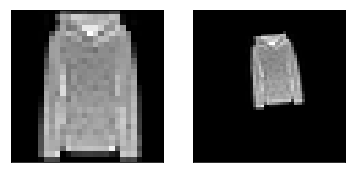

In [6]:
pt,idx = plot_ovt(DL,cmap='gray')

In [7]:
# trainer.build_model()
trainer.compile_model()
trainer.G.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
G_input (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 3136)         97216       G_input[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 64)     0           dense_3[0][0]                    
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 14, 14, 64)   0           reshape_1[0][0]                  
__________________________________________________________________________________________________
block_1_BN

In [8]:
from keras.utils import to_categorical
RF = to_categorical(np.ones(len(DL.sx_train)),num_classes=2)

In [9]:
trainer.go(x=DL.sx_train,
           y={'class':DL.y_train_oh,'D':RF,'G':DL.sx_train},
           validation_split=0.05,
           verbose=0)

Epoch:  0
{'val_G_loss': 59.70213139851888, 'val_G_mse': 59.70213139851888, 'D_loss': 0.02944548243127371, 'loss': 2450.8376976939417, 'val_class_acc': 0.2519999980926514, 'val_D_loss': 0.0043319763460507, 'G_mse': 120.82340516796447, 'class_loss': 3.333564128942657, 'val_class_loss': 2.0299519074757892, 'class_acc': 0.15212280705100611, 'G_loss': 120.82340516796447, 'val_loss': 1214.5347841796874}
Epoch:  1
{'val_G_loss': 54.662593780517575, 'val_G_mse': 54.662593780517575, 'D_loss': 0.003924090574511833, 'loss': 882.3112424530565, 'val_class_acc': 0.39766666722297667, 'val_D_loss': 0.0052599896589914956, 'G_mse': 43.22577373250326, 'class_loss': 1.7591565947114376, 'val_class_loss': 1.5834218174616497, 'class_acc': 0.34678947371349, 'G_loss': 43.22577373250326, 'val_loss': 1109.2559729817708}
Epoch:  2
{'val_G_loss': 37.400862416585284, 'val_G_mse': 37.400862416585284, 'D_loss': 0.005800711856207304, 'loss': 669.4749026864035, 'val_class_acc': 0.5253333304723103, 'val_D_loss': 0.0070

In [10]:
# trainer.go_gen(DL.train_generator(batch_size=128),verbose=1)

In [11]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

,D_loss,G_loss,G_mse,class_acc,class_loss,loss,val_D_loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss
0,0.029445,120.823405,120.823405,0.152123,3.333564,2450.837698,0.004332,59.702131,59.702131,0.252000,2.029952,1214.534784
1,0.003924,43.225774,43.225774,0.346789,1.759157,882.311242,0.005260,54.662594,54.662594,0.397667,1.583422,1109.255973
2,0.005801,32.744989,32.744989,0.470281,1.437372,669.474903,0.007078,37.400862,37.400862,0.525333,1.317189,761.383366
3,0.010598,28.196716,28.196716,0.533526,1.274260,576.888116,0.014886,32.403804,32.403804,0.532333,1.231300,660.593796
4,0.017246,25.758233,25.758233,0.566421,1.178257,527.151355,0.019620,26.945424,26.945424,0.598333,1.108902,550.181012


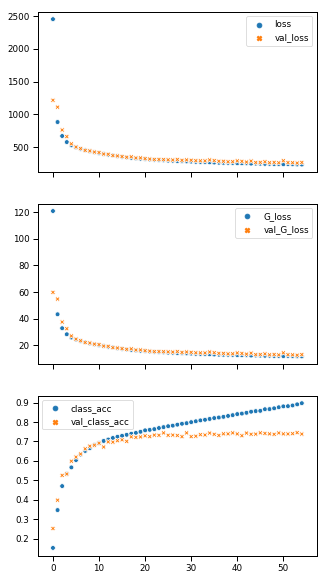

In [12]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [13]:
if not config.dev_mode:
    trainer.save_model()

In [14]:
from keras.models import Model
from keras.layers import Input

In [15]:
generator = trainer.G

In [17]:
z_encoder = Model(trainer.E.input,trainer.z_lat)
classifier = Model(trainer.E.input,trainer.y_class)
# y_lat_encoder = Model(trainer.E.input,trainer.y_lat)
# decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
# dec_layers = trainer.model.layers[-(1+(5*2)):]
# print(dec_layers)
# _gen_x = dec_layers[0](decoder_inp)
# l = dec_layers[1]
# isinstance(l,keras.layers.core.Reshape)
# F = None
# for l in dec_layers[1:]:
#     print(type(l))
    
#     if isinstance(l,keras.layers.merge.Add):
#         _gen_x = l([F,_gen_x])
#     else:
#         _gen_x = l(_gen_x)
    
#     if isinstance(l,keras.layers.convolutional.Conv2DTranspose):
#         if l.kernel_size==(1,1):
#             F = _gen_x
            
# # generator = Model(decoder_inp,_gen_x)

In [18]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6002000   
_________________________________________________________________
class (Dense)                (None, 10)                20010     
Total params: 15,433,010
Trainable params: 15,433,010
Non-trainable params: 0
_________________________________________________________________


In [19]:
DL.y_test_oh.shape

(10000, 10)

In [20]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

10000/10000 [==============================] - 0s 45us/step


[0.7598835624694824, 0.7301999996185303]

In [22]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_lat = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [23]:
_lat_vec = np.concatenate([y_lat,z_enc],axis=1)
_lat_vec.shape

(10000, 30)

In [24]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [25]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

(50, 20)

In [26]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

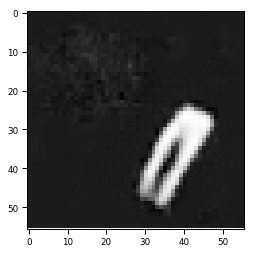

In [27]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [28]:
_lat_vec[rand_im]

array([ 6.4103335e-07,  9.9996078e-01,  6.1980694e-07,  9.2412158e-08,
        1.9509083e-05,  1.6939024e-05,  1.1057994e-06,  3.0379756e-08,
        6.1682051e-14,  3.0658714e-07, -3.0337742e+01, -2.1438650e+01,
       -1.2074148e+01,  2.1427259e+01,  1.2404283e+01, -6.0579529e+00,
       -1.6328756e+01, -8.2629830e-01,  2.2945683e+01, -1.5840717e+01,
       -1.2910404e+01, -2.5423229e+01, -1.8642840e+00,  1.1273558e+01,
       -3.3800861e+01,  1.6793980e+01, -2.7514164e+01, -3.6939940e+00,
       -8.6906737e-01,  2.7290373e+00], dtype=float32)

In [29]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=0.10,
                         translation=0.9,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.9
rot_max:  0.1
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


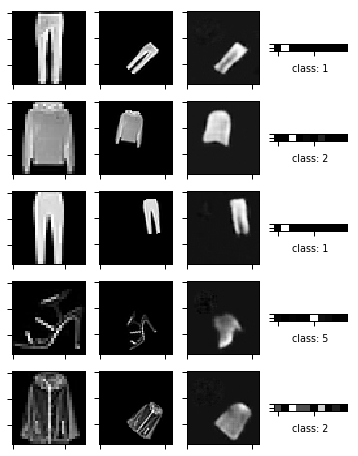

In [30]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_lat,generator)

In [32]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = classifier.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [33]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

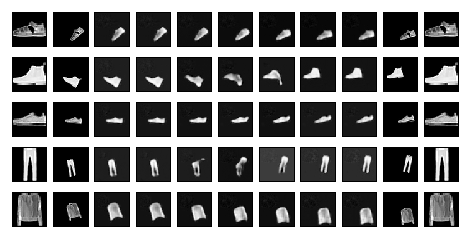

In [36]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_lat[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [37]:
from src.metrics import var_expl
dxs = DL.dx[1]-14
dys = DL.dy[1]-14
dtheta = DL.dtheta[1]
fve_dx = var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = var_expl(features=z_enc,cond=dys,bins=21)
fve_dt = var_expl(features=z_enc,cond=dtheta,bins=21)

In [38]:
fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
fve_dy_norm = (dys.var()-fve_dy)/dys.var()
fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()

In [39]:
import seaborn as sns
sns.set_context('talk')

In [40]:
fve_dx_norm.shape

(21, 20)

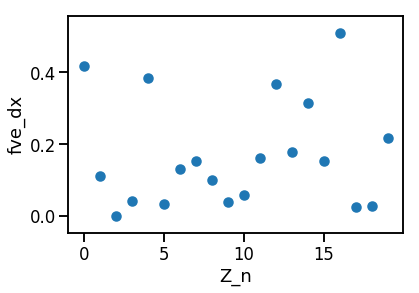

In [41]:
plt.scatter(np.arange(config.z_dim),fve_dx_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dx')
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [42]:
fve_dy_norm.mean(axis=0)

array([ 0.32757472,  0.37466104,  0.21828141,  0.12830254,  0.21472985,
       -0.01093829,  0.52509339,  0.0066142 ,  0.40908231,  0.17230675,
        0.22101319,  0.35133925,  0.00343051, -0.04884171,  0.07849405,
        0.35194901,  0.07612246, -0.01836442,  0.03989543,  0.04883784])

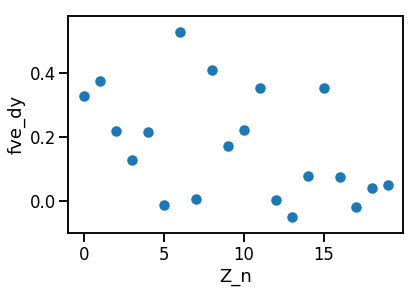

In [43]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

13

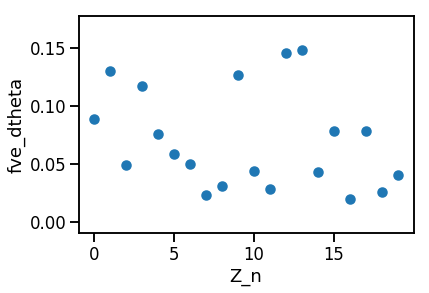

In [44]:
plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dtheta')
# plt.ylim(0.0,0.5)
np.argmax(fve_dth_norm.mean(axis=0))

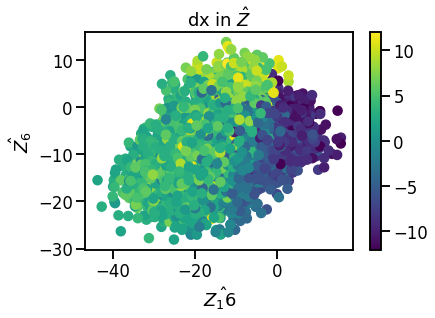

In [45]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

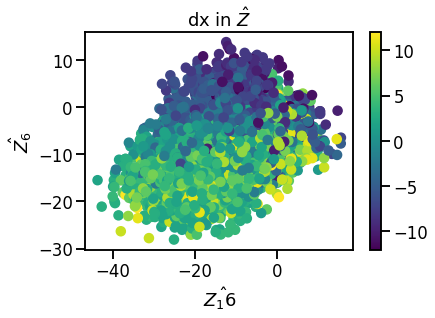

In [46]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

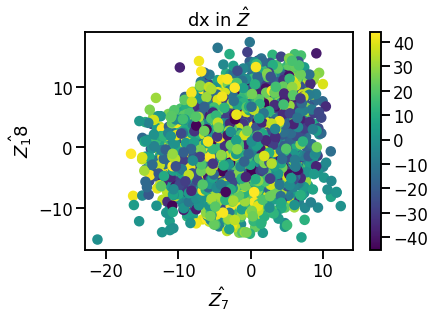

In [47]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.